# Autoencoders, data projection and investigating a learned NN

0. Basics

 - Imports
 - Import and normalize Mnist data

1. Learning Representation with Autoencoders (partial import from keras blog)

 - Standard Autoencoder
 - Variants of autoencoders
 - Variational autoencoders
 - Deep autoencoders
 
2. Using Autoencoders for projecting data in a 2D plot 

3. Identifying the input in the training set that most activates a hidden unit

4. Finding stimulus that fires most a hidden neuron by gradient descent

5. Denoising images

6. Comparing variants of autoencoders as preprocessing models

## Basics

### Imports


In [3]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
from keras import backend as K 
%matplotlib inline

Using TensorFlow backend.


### Importing a predefined dataset (and normalization)

In [2]:
from keras.datasets import mnist
import numpy as np
from keras.utils import np_utils

(x_train, y_train), (x_test, y_test) = mnist.load_data()

nb_classes = 10

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
Y_train = y_train
Y_test = y_test
y_train =  np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print(x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

11493376/11490434 [==============================] - 117s 10us/step
(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [3]:
# Examples of import from Keras

from keras.layers import Input, Dense
from keras.models import Model

In [4]:
# use Matplotlib (don't ask)
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Learning Representation with Autoencoders (partial import from keras blog)

### 1.1. Standard Autoencoder 


In [5]:
# this is the size of our encoded representations
encoding_dim = 32
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# theano.printing.pydotprint(decoded, outfile="f.png", var_with_name_simple=True)

/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [6]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [7]:
autoencoder.compile(optimizer='adam', loss='mse')

#### Nombre de paramètres du modèle


Affichez la structure du modèle et retrouvez le nombre de paramètres à partir des dimensions des différentes couches.


In [14]:
h = autoencoder.fit(x_train, x_train,
                nb_epoch=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.summary()

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 8448/60000 [===>..........................] - ETA: 0s - loss: 0.0260

/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


60000/60000 [==============================] - 1s 25us/step - loss: 0.0246 - val_loss: 0.0228
Epoch 2/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0222 - val_loss: 0.0210
Epoch 3/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.0208 - val_loss: 0.0199
Epoch 4/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.0199 - val_loss: 0.0191
Epoch 5/20
60000/60000 [==============================] - 2s 27us/step - loss: 0.0193 - val_loss: 0.0186
Epoch 6/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0189 - val_loss: 0.0183
Epoch 7/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.0186 - val_loss: 0.0181
Epoch 8/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.0184 - val_loss: 0.0179
Epoch 9/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.0182 - val_loss: 0.0178
Epoch 10/20
60000/60000 [==============================] - 2s 31us

Intérprétez la valeur du critère sur la base d'apprentssage en termes d'erreur moyenne de prédictiokn du niveau de gris d'un pixel de l'image

dict_keys(['val_loss', 'loss'])


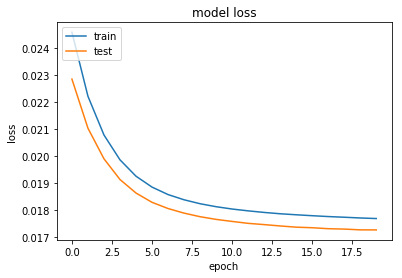

In [15]:
history = h 

print (history.history.keys())
# list all data in history
#print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Looking to reconstructed data

In [16]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

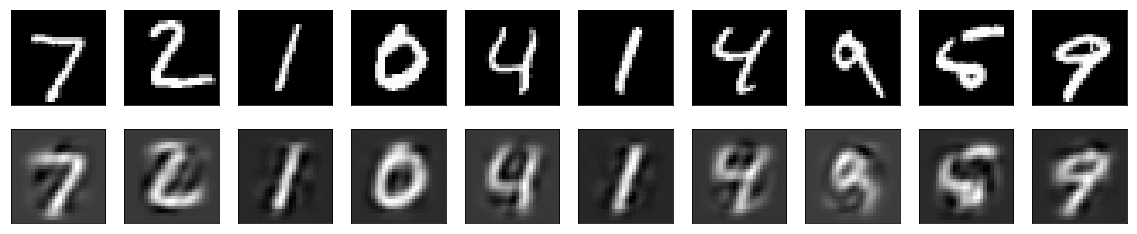

In [17]:

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### To do : plot reconstructed data for different learning iteration numbers

/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 60000 samples, validate on 10000 samples


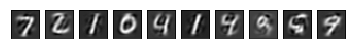

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 25us/step - loss: 0.0174 - val_loss: 0.0170


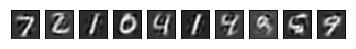

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 2s 29us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/2
60000/60000 [==============================] - 2s 31us/step - loss: 0.0174 - val_loss: 0.0170


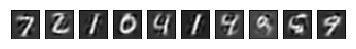

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 2s 29us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/3
60000/60000 [==============================] - 2s 30us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/3
60000/60000 [==============================] - 1s 23us/step - loss: 0.0174 - val_loss: 0.0170


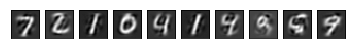

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s 22us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/4
60000/60000 [==============================] - 1s 24us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/4
60000/60000 [==============================] - 2s 27us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/4
60000/60000 [==============================] - 2s 26us/step - loss: 0.0174 - val_loss: 0.0170


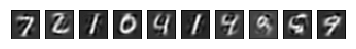

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 23us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/5
60000/60000 [==============================] - 1s 19us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 5/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.0174 - val_loss: 0.0170


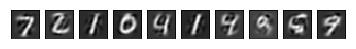

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 1s 17us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/6
60000/60000 [==============================] - 2s 32us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/6
60000/60000 [==============================] - 2s 29us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/6
60000/60000 [==============================] - 2s 26us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 5/6
60000/60000 [==============================] - 2s 26us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 6/6
60000/60000 [==============================] - 2s 33us/step - loss: 0.0174 - val_loss: 0.0170


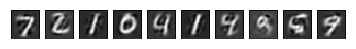

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 2s 27us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/7
60000/60000 [==============================] - 2s 30us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/7
60000/60000 [==============================] - 2s 26us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/7
60000/60000 [==============================] - 2s 25us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 5/7
60000/60000 [==============================] - 2s 25us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 6/7
60000/60000 [==============================] - 2s 30us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 7/7
60000/60000 [==============================] - 2s 26us/step - loss: 0.0174 - val_loss: 0.0170


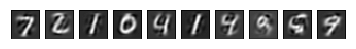

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 1s 21us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/8
60000/60000 [==============================] - 2s 35us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/8
60000/60000 [==============================] - 2s 35us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/8
60000/60000 [==============================] - 2s 37us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 5/8
60000/60000 [==============================] - 2s 35us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 6/8
60000/60000 [==============================] - 2s 36us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 7/8
60000/60000 [==============================] - 2s 26us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 8/8
60000/60000 [==============================] - 2s 28us/step - loss: 0.0174 - val_loss: 0.0170


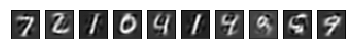

Train on 60000 samples, validate on 10000 samples
Epoch 1/9
60000/60000 [==============================] - 2s 30us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 2/9
60000/60000 [==============================] - 2s 31us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/9
60000/60000 [==============================] - 2s 32us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 4/9
60000/60000 [==============================] - 2s 29us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 5/9
60000/60000 [==============================] - 2s 34us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 6/9
60000/60000 [==============================] - 2s 29us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 7/9
60000/60000 [==============================] - 2s 34us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 8/9
60000/60000 [==============================] - 2s 27us/step - loss: 0.0174 - val_loss: 0.0170
Epoch 9/9
60000/60000 [==============================] - 2s 28us/step - loss: 0.0174 - val_loss: 0.0170


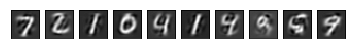

In [19]:
n = 10  # how many digits we will display
#plt.figure(figsize=(20, 4))

for j in range(10):
    
    h = autoencoder.fit(x_train, x_train,
                nb_epoch=j,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
    
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Exploring learned filters

In [20]:
W_Input2Hidden = autoencoder.get_weights()[0]
print (W_Input2Hidden.shape)


(784, 32)


In [21]:
import pylab

def affiche_filtres(model, nfiltres):
    W_Input2Hidden = autoencoder.get_weights()[0]
    plt.figure(figsize=(20, 20))
    for i in range(nfiltres):
        # display original
        ax = plt.subplot(nfiltres/5+1, 5 , (i+1))

        plt.imshow(W_Input2Hidden[:,i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    
def sauve_figure_filtres(model, nfiltres, name):
    W_Input2Hidden = autoencoder.get_weights()[0]
    fig = plt.figure(figsize=(20, 20))
    plt.savefig(name) 
    for i in range(nfiltres):
        # display original
        ax = plt.subplot(nfiltres/5+1, 5 , (i+1))

        plt.imshow(W_Input2Hidden[:,i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    #plt.show()
    plt.show()  
    plt.close(fig)
    
    
    
    

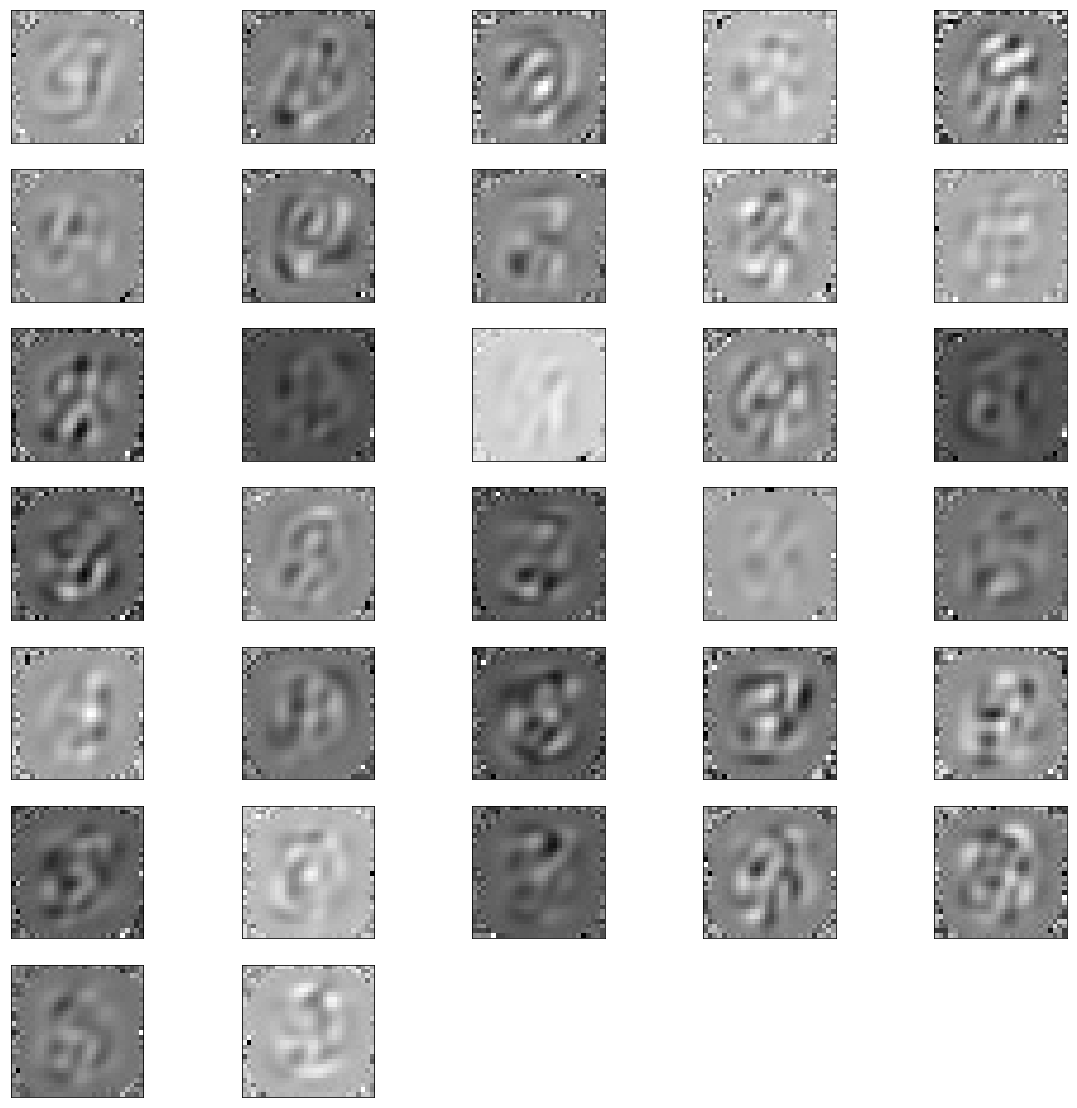

In [22]:
sauve_figure_filtres(autoencoder, encoding_dim, "Standard")

### 1.2 Programming variants

Can you get better filters with variants of autoencoders such as the following ?
Programmez te testez les modèles suivants: 

- Denoising autoencoders
Les denoising autoencoders bruitent les données d'entrée mais visent à reconstruire les données non bruitées en sortie
Utilisez la couche GaussianNoise

- Sparse autoencoders
Les sparese autoencoders ajoutent une pénalité L1 sur les activations des neurons de la couche cachée. Vous utiliserez un activity_regularizer=regularizers.l1 dans la définition de la couche cachée calculant l'encodage des données d'entrée 

- Deep autoencoder
Programmez un deep autoencoder avec plusieurs couches cachées successives dans l'encoder, et dans le decoder, et réalisez son apprentissage. 
Usuellement on utilise des couches de plus en plus petites dans la artie encodage et des ciuches de plus en plus grandes dans le décodage. Vérifiez que l'erreur de reconstruction est plus petit qu'avec les auto encoderus précédents ?


/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0653 - val_loss: 0.0476
Epoch 2/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0468 - val_loss: 0.0373
Epoch 3/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.0420 - val_loss: 0.0326
Epoch 4/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0398 - val_loss: 0.0298
Epoch 5/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0387 - val_loss: 0.0284
Epoch 6/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.0381 - val_loss: 0.0274
Epoch 7/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.0377 - val_loss: 0.0267
Epoch 8/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0374 - val_loss: 0.0263
Epoch 9/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.0372 - val_loss: 0.0261
Epoch

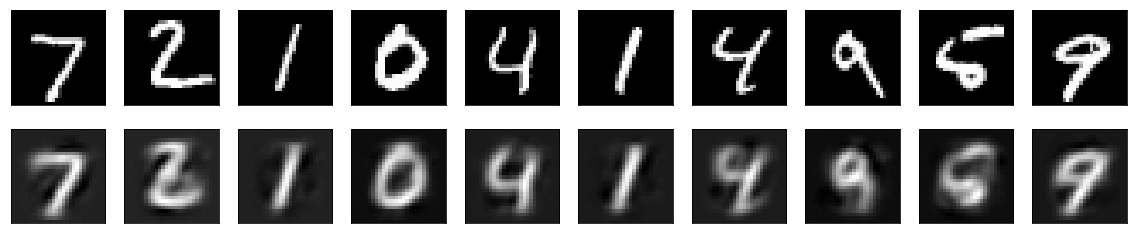

In [38]:
import keras

# this is the size of our encoded representations
encoding_dim = 32
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
noise = keras.layers.GaussianNoise(1)(input_img)
encoded = Dense(encoding_dim, activation='sigmoid')(noise)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# theano.printing.pydotprint(decoded, outfile="f.png", var_with_name_simple=True)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.summary()

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/raphael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.0637 - val_loss: 0.0475
Epoch 2/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0410 - val_loss: 0.0355
Epoch 3/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.0323 - val_loss: 0.0293
Epoch 4/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0278 - val_loss: 0.0260
Epoch 5/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.0253 - val_loss: 0.0241
Epoch 6/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0239 - val_loss: 0.0230
Epoch 7/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.0230 - val_loss: 0.0223
Epoch 8/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.0225 - val_loss: 0.0219
Epoch 9/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.0222 - val_loss: 0.0216
Epoch

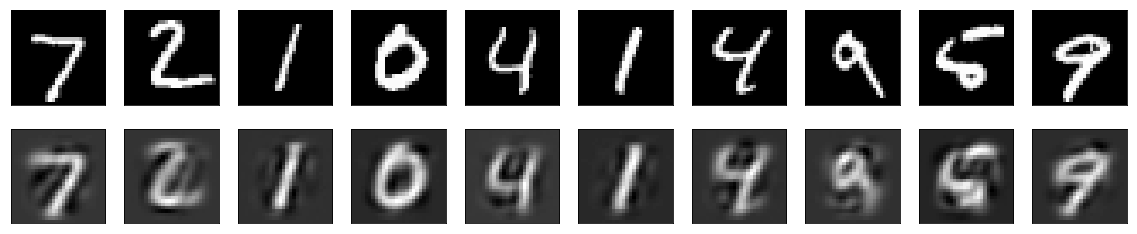

In [44]:
import keras

# this is the size of our encoded representations
encoding_dim = 32
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='sigmoid', activity_regularizer=keras.regularizers.l1(0.000001))(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# theano.printing.pydotprint(decoded, outfile="f.png", var_with_name_simple=True)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.summary()

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import keras

# this is the size of our encoded representations
encoding_dim = 32
intermediate_1 = 512
intermidiate_2 = 128
intermidiate_3 = 58
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# theano.printing.pydotprint(decoded, outfile="f.png", var_with_name_simple=True)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

h = autoencoder.fit(x_train, x_train,
                nb_epoch=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.summary()

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 1.3 comparing variants

1. Compare the filters implemebted by hidden neurons of the first hidden layer of few autoencoders variants after learning is complete.

2. For a given representation dimensionn use GridSearch for tuning the hyperparameters of your autoencoders (ativation function, number and size of layers, optimization routine...) and compare them with respect to error reconstruction on your dataset.


## 2. Using Autoencoders for projecting data in a 2D plot



Using autoencoders with embedding size equal to 2 you may project data nonlinearly in a latant space.

Perform such a projection with a stadard autoencoder and a deep autoencoder and plot the projected data with class numbers.

## 3. Identifying the input in the training set that most activates a hidden unit

A popular way to investigate what is learned by particular neurons of a neural network is to determine the input data from the trainng set that most activtates the neuron.

Implement this method where you will plot a number (e.g. 10) of input samples that most fires a given neuron in a hidden layer. Test it on a single hidden layer autoencoder as well as on hidden layers of a deep autoencoder. 


## 4. Finding stimulus that fires most a hidden neuron by gradient descent

Ecrivez un code qui permet de déytermoner par descente de gradient l'entrée qui active le plus un neurone particulier d'une couche cachée.

Il vous faut:
i/ Définir une fonction du backend K par K.function qui prend en argument une donnée d'entrée  et retourne le loss et le gradient associé où le loss est l'activation de la cellule considérée 

ii/ Calculer le gradient par K.gradients 

iii/ Ecrire une boucle qui implémente la descente de gradient avec ce que vous venez d'écrire

iv/ Utiliser ce que vous venez de faire pour afficher l'image d'entrée qui active le plus chacun des neurones d'une couche cachée

In [ ]:
# Vous pouvez utiliser le code suivant pour accéder aux couches d'un réseau de neurones 

layer_dict = dict([(layer.name, layer) for layer in encoder.layers])
print (layer_dict)

## 5. Denoising images

Autoencoders may be used to denoise input data. Denoising autoecnoders are good at that but any autoencoder should be able to do so. You can test it with Mnist data by first generating a noisy version of these, then by looking at reconstructed data at the output of an autoencoder when fed with noisy mnist images.

Explore the potential of autoencoders for this task.


## 6. Comparing variants of autoencoders as preprocessing models 

Compare variants of autoencoders to preprocess mnist data before using a logistic regression classifier

The approach of learning first an autoencoder to project data into a new representation space then learn a linear classifier in this space is suboptimal when compared to learning jointly to project in the new representation space and to classify data in this latter space as done in Multi Layer Perceptrons.

Yet it might be of interest if you get lots of unlabeled training data and few labeled ones since the learning of an autoencoder does not require label information and thus may be accurately learned from a large collection of unlabeled training data.

You shhould compare the performance of a pipeline (New representation of data using an Autoencoder + Linear classifier) and of a MLP as a function of the number of labeled trainng data.

 